In [1]:
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import ot
import pandas as pd
import seaborn as sns
import sklearn
import time
import warnings

import condo

_ = time.time()  # warmup

In [2]:
num_random = 10

Ns = [10, 20, 50, 100, 200]
Ns_np = np.array(Ns)
rmses = {} # method -> (num_Ns, num_random) array
times = {} # method -> (num_Ns, num_random) array
methods = [
    "source - true (unobserved)", "source - batch-effected",
    "source - Gaussian OT", "source - MMD",
    "source - ConDo Linear-ReverseKL", "source - ConDo GP-ReverseKL", "source - ConDo MMD"
]
for method in methods:
    rmses[method] = np.zeros((len(Ns), num_random))
    times[method] = np.zeros((len(Ns), num_random))

mmd_alpha = {
    10: 1e-2,
    20: 1e-2,
    50: 1e-2,
    100: 1e-4,
    200: 1e-5,
}
    
for nix, N in enumerate(Ns):
    
    for rix in range(num_random):
        print(f"running N:{N} rix:{rix}") 
        rng = np.random.RandomState(rix)

        N_T = N
        N_S = N

        # How confounder X affects the distribution of T and S
        mu_hotdog = 5.
        sigma_hotdog = 1.0
        mu_not = 0.0
        sigma_not = 2.0

        # How batch effect affects S
        batch_m = 2 * np.ones((1, 1))
        batch_b = 5 * np.ones((1, 1))
        # The true batch correction from Sbatch to S
        true_m = 1. / batch_m
        true_b = -1 * batch_b / batch_m

        n_hotdogT = round(3 * N_T / 4)
        n_notT = N_T - n_hotdogT
        n_hotdogS = round(N_S / 4)
        n_notS = N_S - n_hotdogS
        X_T = np.array([['hotdog']*n_hotdogT + ['not_hotdog']*n_notT]).reshape((N_T, 1))
        X_S = np.array([['hotdog']*n_hotdogS + ['not_hotdog']*n_notS]).reshape((N_S, 1))
        Strue = np.nan * np.ones((N_S, 1))
        T = np.nan * np.ones((N_T, 1))
        Strue[np.where(X_S[:,0] == 'hotdog'), 0] = np.random.normal(
            mu_hotdog, sigma_hotdog, size=(n_hotdogS))
        T[np.where(X_T[:,0] == 'hotdog'), 0] = np.random.normal(
            mu_hotdog, sigma_hotdog, size=(n_hotdogT))
        Strue[np.where(X_S[:,0] == 'not_hotdog'), 0] = np.random.normal(
            mu_not, sigma_not, size=(n_notS))
        T[np.where(X_T[:,0] == 'not_hotdog'), 0] = np.random.normal(
            mu_not, sigma_not, size=(n_notT))

        Sbatch = Strue @ batch_m.T + batch_b

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            lter = ot.da.LinearTransport()
            start_time = time.time()
            lter.fit(Xs=Sbatch, Xt=T)
            Sotda = lter.transform(Xs=Sbatch)
            times["source - Gaussian OT"][nix, rix] = time.time() - start_time

            nder = condo.MMDAdapter(
                transform_type="location-scale",
                optim_kwargs={"alpha": mmd_alpha[N], "beta": 0.9999},
                debug=False,
                verbose=0
            )
            start_time = time.time()
            nder.fit(Sbatch, T)
            Smmd = nder.transform(Sbatch)
            times["source - MMD"][nix, rix] = time.time() - start_time

            cder = condo.ConDoAdapter(
                sampling="proportional",
                transform_type="location-scale",
                divergence="reverse",
                model_type="linear",
                debug=False,
                verbose=0,
            )
            start_time = time.time()
            cder.fit(Sbatch, T, X_S, X_T)
            Sclinear = cder.transform(Sbatch)
            times["source - ConDo Linear-ReverseKL"][nix, rix] = time.time() - start_time

            cder = condo.ConDoAdapter(
                sampling="proportional",
                transform_type="location-scale",
                divergence="reverse",
                model_type="heteroscedastic-gp",
                debug=False,
                verbose=0,
            )
            start_time = time.time()
            cder.fit(Sbatch, T, X_S, X_T)
            Scgp = cder.transform(Sbatch)    
            times["source - ConDo GP-ReverseKL"][nix, rix] = time.time() - start_time

            cder = condo.ConDoAdapter(
                sampling="proportional",
                transform_type="location-scale",
                divergence="mmd",
                model_type="empirical",
                optim_kwargs={"alpha": 1e-5, "beta": 0.9},
                debug=False,
                verbose=0
            )
            start_time = time.time()
            cder.fit(Sbatch, T, X_S, X_T)
            Scmmd = cder.transform(Sbatch)
            times["source - ConDo MMD"][nix, rix] = time.time() - start_time

        dfT = pd.concat([
            pd.DataFrame(T, columns=['variable']), pd.DataFrame(X_T, columns=['confounder'])
        ], axis=1)
        dfT["batch"] = "target"

        dfStrue = pd.concat([
            pd.DataFrame(Strue, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfStrue["batch"] = "source - true (unobserved)"
        rmses["source - true (unobserved)"][nix, rix] = ((dfStrue.variable - dfStrue.variable) ** 2).mean() ** 0.5

        dfSbatch = pd.concat([
            pd.DataFrame(Sbatch, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfSbatch["batch"] = "source - batch-effected"
        rmses["source - batch-effected"][nix, rix] = ((dfStrue.variable - dfSbatch.variable) ** 2).mean() ** 0.5

        dfSotda = pd.concat([
            pd.DataFrame(Sotda, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfSotda["batch"] = "source - Gaussian OT"
        rmses["source - Gaussian OT"][nix, rix] = ((dfStrue.variable - dfSotda.variable) ** 2).mean() ** 0.5

        dfSmmd = pd.concat([
            pd.DataFrame(Smmd, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfSmmd["batch"] = "source - MMD"
        rmses["source - MMD"][nix, rix] = ((dfStrue.variable - dfSmmd.variable) ** 2).mean() ** 0.5

        dfSclinear = pd.concat([
            pd.DataFrame(Sclinear, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfSclinear["batch"] = "source - ConDo Linear-ReverseKL"
        rmses["source - ConDo Linear-ReverseKL"][nix, rix] = ((dfStrue.variable - dfSclinear.variable) ** 2).mean() ** 0.5

        dfScgp = pd.concat([
            pd.DataFrame(Scgp, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfScgp["batch"] = "source - ConDo GP-ReverseKL"
        rmses["source - ConDo GP-ReverseKL"][nix, rix] = ((dfStrue.variable - dfScgp.variable) ** 2).mean() ** 0.5

        dfScmmd = pd.concat([
            pd.DataFrame(Scmmd, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
        ], axis=1)
        dfScmmd["batch"] = "source - ConDo MMD"
        rmses["source - ConDo MMD"][nix, rix] = ((dfStrue.variable - dfScmmd.variable) ** 2).mean() ** 0.5

        df = pd.concat([dfT, dfStrue, dfSbatch, dfSotda, dfSmmd, dfSclinear, dfScgp, dfScmmd], axis=0)

        fig = plt.figure(dpi=150, figsize=(6, 4));
        figname = f"figure-categorical1d-{N}-{rix}.pdf"
        sns.stripplot(
            x="confounder",
            y="variable",
            hue="batch",
            jitter=0.3,
            dodge=True,
            s=3,
            data=df)
        plt.legend(
            title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
            frameon=False,
        );
        if rix == num_random - 1:
            fig.savefig(figname, bbox_inches="tight")
        plt.close();

running N:10 rix:0
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:1
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:2
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:3
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:4
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:5
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:6
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:7
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:8
fix:0/1
fix:0/1
fix:0/1
running N:10 rix:9
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:0
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:1
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:2
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:3
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:4
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:5
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:6
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:7
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:8
fix:0/1
fix:0/1
fix:0/1
running N:20 rix:9
fix:0/1
fix:0/1
fix:0/1
running N:50 rix:0
fix:0/1
fix:0/1
fix:0/1
running N:50 rix:1
fix:0/1
fix:0/1
fix:0/1
running N:50 rix:2
fix:0/1
fix:0/1
fix:0/1
running N:5

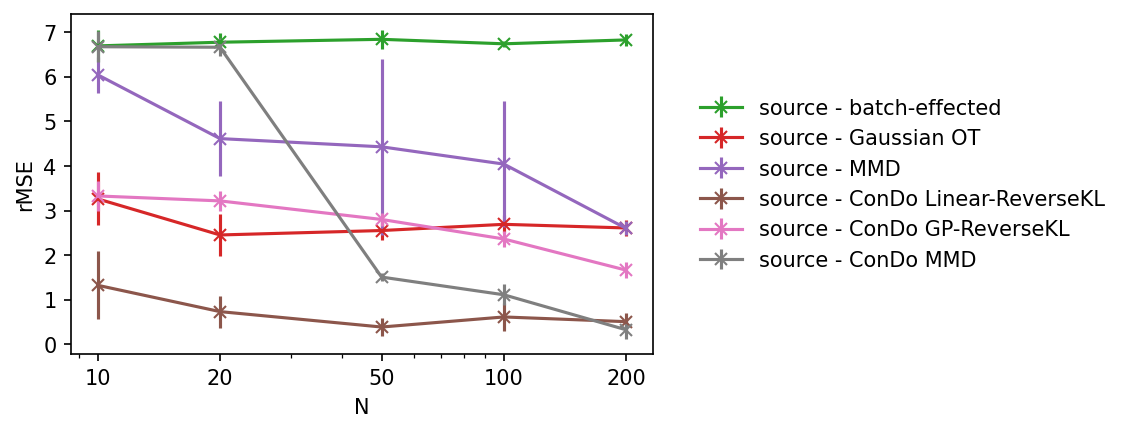

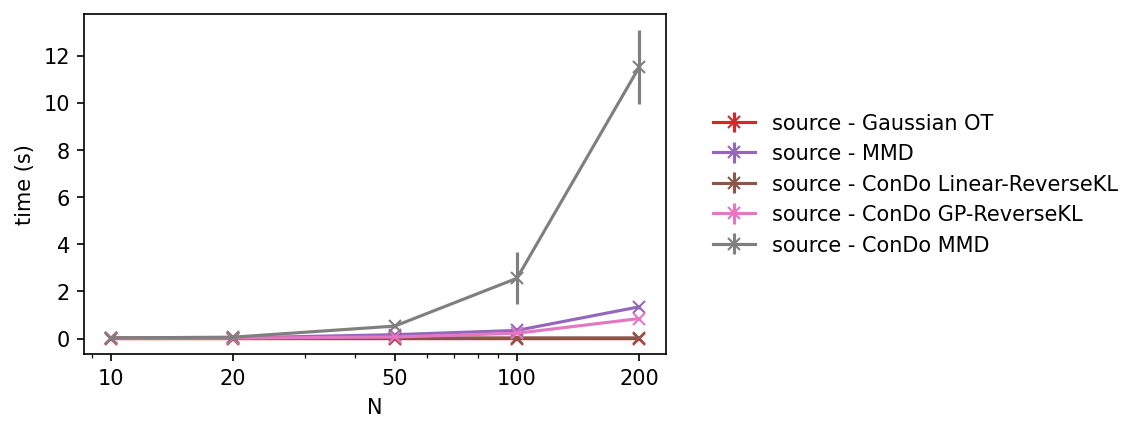

In [3]:
fig = plt.figure(dpi=150, figsize=(5, 3))
for _ in range(2):
    # skip target, source-true
    next(plt.gca()._get_lines.prop_cycler)

for method in methods[1:]:
    # skip true (always 0)
    plt.errorbar(Ns_np, np.mean(rmses[method], axis=1), yerr=np.std(rmses[method], axis=1), marker='x');
plt.ylabel('rMSE');
plt.xlabel('N');
plt.xscale('log');
plt.xticks(Ns, Ns);
plt.legend(
    methods[1:],
    title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False,
);
figname = f"figure-categorical1d-rmses-{rix}.pdf"
fig.savefig(figname, bbox_inches="tight")

fig = plt.figure(dpi=150, figsize=(5, 3))
for _ in range(3):
    # skip target, source-true, source-batch
    next(plt.gca()._get_lines.prop_cycler)

for method in methods[2:]:
    # skip source-true, source-batch
    plt.errorbar(Ns_np, np.mean(times[method], axis=1), yerr=np.std(times[method], axis=1), marker='x');
plt.ylabel('time (s)');
plt.xlabel('N');
plt.xscale('log');
plt.xticks(Ns, Ns);
plt.legend(
    methods[2:],
    title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False,
);
figname = f"figure-categorical1d-times-{rix}.pdf"
fig.savefig(figname, bbox_inches="tight")